In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

In [2]:
#生成随机数列表
def RandomIntList(start, stop, number):
    start, stop = (int(start), int(stop)) if start <= stop else (int(stop), int(start))
    number = int(abs(number)) if number else 0
    random_list = []
    for i in range(number):
        random_list.append(random.randint(start, stop))
    return random_list

In [3]:
#loss函数，loss = np.dot(w.T.w)/2 + ln(1+exp(yi  * Xi * w))
def Loss(X,y,w):
    n_sample,n_feature = X.shape
    f1 = y * np.dot(X,w)   #yi * Xi *w
    loss = np.sum(np.log(np.exp(-f1) + 1))/n_sample #(1/n) * sum(ln(1+exp(-ywx)))
    return (loss + np.dot(w.T,w)[0,0]/2)

In [4]:
#计算梯度
def Gradient(X,y,w):
    n_sample,n_feature = X.shape
    gradient = -(y * X) / (1 + np.exp(y * np.dot(X,w)))
    return ( w.T +(gradient.mean(axis = 0)).reshape(1,n_feature)) #返回随机梯度，为二维行向量

In [5]:
def RMSProp(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,test_loss):
    n_sample,n_feature = X_train.shape
    w = np.zeros((n_feature,1))
    lr = 0.001
    t = 0.9 #伽马
    G = np.zeros((n_feature,1))
    c = np.power(10.0,-8)
    for i in range(iteration):
       #用随机数列表构造批量数据的矩阵，用来计算批量梯度
        X_batch = np.array([X_train[j] for j in (random_list[i])],dtype = int).reshape(batchSize,n_feature)
        y_batch = np.array([y_train[j] for j in (random_list[i])],dtype = int).reshape(batchSize,1)  
        grad = Gradient(X_batch,y_batch,w).T
        #c = np.power(10.0,-8) #移到了循环外
        G = t * G + (1-t)*(grad*grad)
        w = w - (lr / np.sqrt(G + c) * grad)
        test_loss.append(Loss(X_test,y_test,w))
    return w

In [6]:
def AdaDelta(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,test_loss):
    n_sample,n_feature = X_train.shape
    w = np.zeros((n_feature,1))
    gamma = 0.95
    delta_t = np.zeros((n_feature,1))
    c = np.power(10.0,-8)
    G = np.zeros((n_feature,1))
    for i in range(iteration):
        #用随机数列表构造批量数据的矩阵，用来计算批量梯度
        X_batch = np.array([X_train[j] for j in (random_list[i])],dtype = int).reshape(batchSize,n_feature)
        y_batch = np.array([y_train[j] for j in (random_list[i])],dtype = int).reshape(batchSize,1)
        grad = Gradient(X_batch,y_batch,w).T
        G = gamma * G + (1-gamma) * grad * grad
        delta_w = - (np.sqrt(delta_t + c)/np.sqrt(G + c)) * grad
        w = w + delta_w
        delta_t = gamma * delta_t + (1 - gamma) * delta_w * delta_w
        test_loss.append(Loss(X_test,y_test,w))
    return w

In [7]:
def Adam(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,test_loss):
    w = np.zeros((X_test.shape[1],1))
    gamma = 0.999
    delta_t = np.zeros((X_train.shape[1],1))
    c = np.power(10.0,-8)
    G = np.zeros((X_train.shape[1],1))
    m = np.zeros((X_train.shape[1],1))
    beta = 0.9 #可能需要衰减
    lr = 0.001 #可能需要衰减
    for i in range(iteration):
        #用随机数列表构造批量数据的矩阵，用来计算批量梯度
        X_batch = np.array([X_train[j] for j in (random_list[i])],dtype = int).reshape(batchSize,n_feature)
        y_batch = np.array([y_train[j] for j in (random_list[i])],dtype = int).reshape(batchSize,1)
        grad = Gradient(X_batch,y_batch,w).T
        m = beta * m + (1-beta) * grad
        G = gamma * G + (1 - gamma) * grad * grad
        alpha = lr * np.sqrt(1-np.power(gamma,iteration)) / (1-np.power(beta,iteration))
        w = w - alpha * m / np.sqrt(G + c)
        test_loss.append(Loss(X_test,y_test,w))
    return w

In [20]:
def NAG(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,test_loss):
    w = np.zeros((X_test.shape[1],1))
    gamma = 0.9
    lr = 0.0001
    v = np.zeros((X_train.shape[1],1))
    for i in range(iteration):
        #用随机数列表构造批量数据的矩阵，用来计算批量梯度
        X_batch = np.array([X_train[j] for j in (random_list[i])],dtype = int).reshape(batchSize,n_feature)
        y_batch = np.array([y_train[j] for j in (random_list[i])],dtype = int).reshape(batchSize,1)
        gradient = Gradient(X_batch,y_batch,w-gamma * v).T
        v = gamma * v + lr * gradient
        w = w - v
        test_loss.append(Loss(X_test,y_test,w))
    return w

In [21]:
def Validation(X_test,y_test,w):
    y_result = 1 / (1 + np.exp(-np.dot(X_test,w)))
    y_ = np.zeros((y_test.shape[0],1))
    n = 0
    for i in range(y_test.shape[0]):
        if(y_result[i] > 0.5):
            y_[i] = 1
        else:
            y_[i] = -1
    for i in range(y_test.shape[0]):
        if(y_[i] == y_test[i]):
            n = n + 1
    return (n/y_test.shape[0])

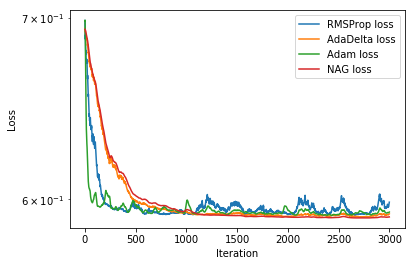

In [22]:
data_train = load_svmlight_file("/home/wade/ML2017-lab-02/a9a.txt")
data_test = load_svmlight_file("/home/wade/ML2017-lab-02/a9a_t.txt")

X_train = data_train[0].toarray()
X_test = data_test[0].toarray()
X_test = np.c_[X_test,np.zeros((X_test.shape[0],1))]
y_train = data_train[1].reshape(X_train.shape[0],1)
y_test = data_test[1].reshape(X_test.shape[0],1)



#w = np.zeros((X_test.shape[1],1))
n_train,n_feature = X_train.shape
RMSProp_loss = []
AdaDelta_loss = []#用来记录梯度下降过程中产生的loss
Adam_loss = []
NAG_loss = []
iteration = 3000#迭代次数
batchSize = 1 #每次梯度下降用到的样本数
#生成随机数矩阵
random_list = np.random.randint(0, n_train-1,iteration * batchSize).reshape(iteration,batchSize)



w1 = RMSProp(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,RMSProp_loss)
w2 = AdaDelta(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,AdaDelta_loss)
w3 = Adam(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,Adam_loss)
w4 = NAG(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,NAG_loss)

plt.yscale('log')
plt.plot(range(iteration),RMSProp_loss,label='RMSProp loss')
plt.plot(range(iteration),AdaDelta_loss,label='AdaDelta loss')
plt.plot(range(iteration),Adam_loss,label ="Adam loss")
plt.plot(range(iteration),NAG_loss,label ="NAG loss")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

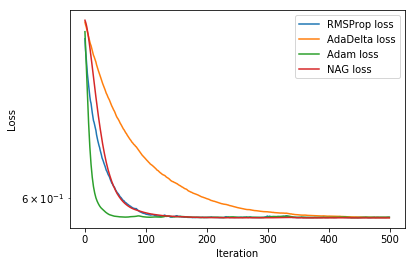

In [14]:
data_train = load_svmlight_file("/home/wade/ML2017-lab-02/a9a.txt")
data_test = load_svmlight_file("/home/wade/ML2017-lab-02/a9a_t.txt")

X_train = data_train[0].toarray()
X_test = data_test[0].toarray()
X_test = np.c_[X_test,np.zeros((X_test.shape[0],1))]
y_train = data_train[1].reshape(X_train.shape[0],1)
y_test = data_test[1].reshape(X_test.shape[0],1)

n_train,n_feature = X_train.shape
RMSProp_loss = []
AdaDelta_loss = []
Adam_loss = [] #用来记录梯度下降过程中产生的loss
NAG_loss = []
iteration = 500 #迭代次数
batchSize = 100 #每次梯度下降用到的样本数
#生成随机数矩阵
random_list = np.random.randint(0, n_train-1,iteration * batchSize).reshape(iteration,batchSize)



RMSProp(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,RMSProp_loss)
AdaDelta(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,AdaDelta_loss)
Adam(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,Adam_loss)
NAG(X_train,y_train,X_test,y_test,iteration,batchSize,random_list,NAG_loss)

plt.yscale('log')
plt.plot(range(iteration),RMSProp_loss,label='RMSProp loss')
plt.plot(range(iteration),AdaDelta_loss,label='AdaDelta loss')
plt.plot(range(iteration),Adam_loss,label ="Adam loss")
plt.plot(range(iteration),NAG_loss,label ="NAG loss")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()